In [1]:
import pandas as pd

# Load dataset (make sure loan_data.csv is in your working folder)
df = pd.read_csv("loan_data.csv")

# First look at the dataset
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Question for students: What do you notice about the columns? Which look numerical? Which are categorical?



In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

Question: How many rows and columns? Are there missing values?



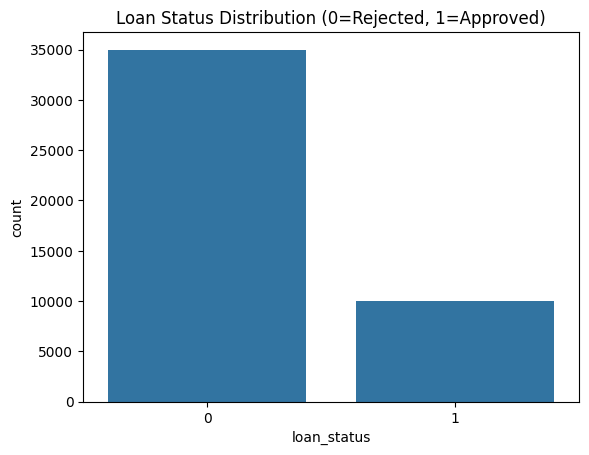

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="loan_status", data=df)
plt.title("Loan Status Distribution (0=Rejected, 1=Approved)")
plt.show()

Question: Is the dataset balanced (equal approved/rejected)? Why does it matter?




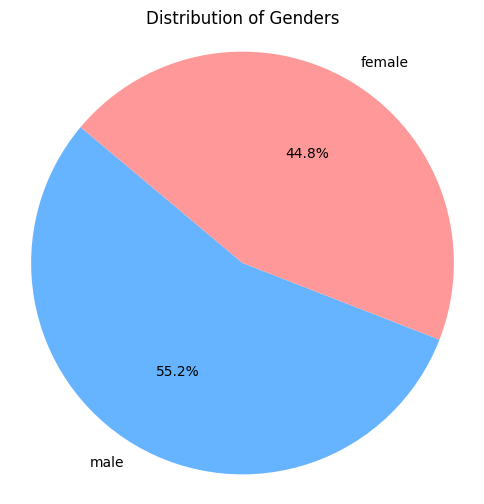

In [4]:
gender_counts = df['person_gender'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=['#66b3ff','#ff9999'])
plt.title("Distribution of Genders")
plt.axis("equal")
plt.show()

Question: Do you think gender should affect loan approval? Why might using gender be problematic?


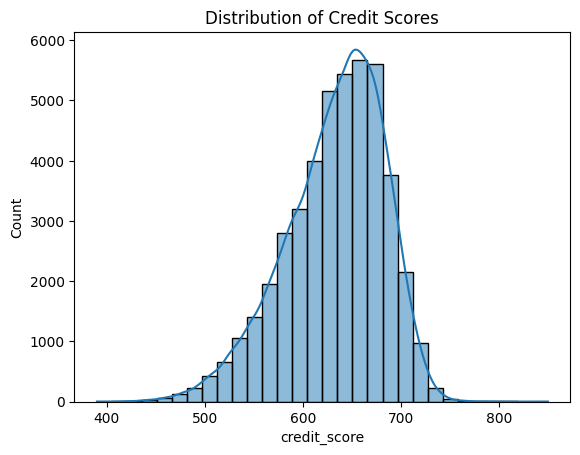

In [5]:
sns.histplot(df['credit_score'], bins=30, kde=True)
plt.title("Distribution of Credit Scores")
plt.show()


Question: What do you expect: will high credit scores increase or decrease loan approval probability?

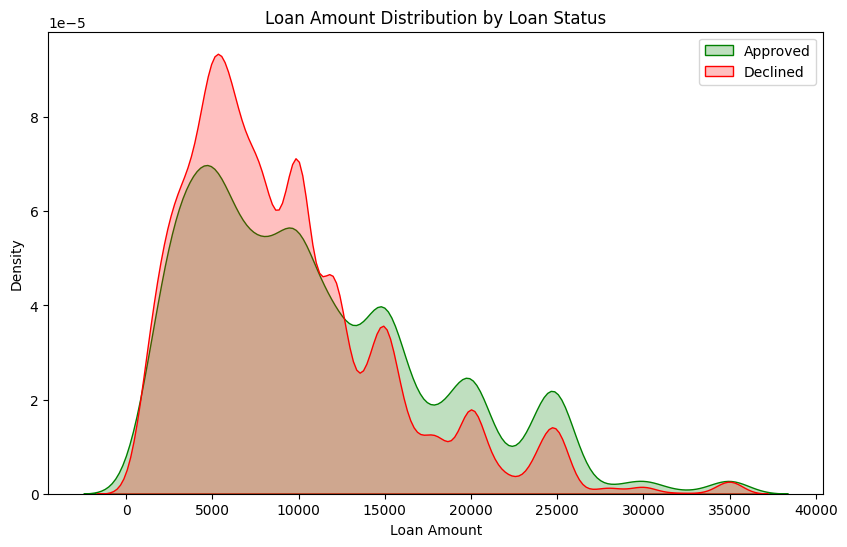

In [6]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['loan_status']==1], x='loan_amnt', label='Approved',
            fill=True, color='green')
sns.kdeplot(data=df[df['loan_status']==0], x='loan_amnt', label='Declined',
            fill=True, color='red')
plt.title("Loan Amount Distribution by Loan Status")
plt.xlabel("Loan Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

Question: Do bigger loans tend to be riskier? What does the plot show?




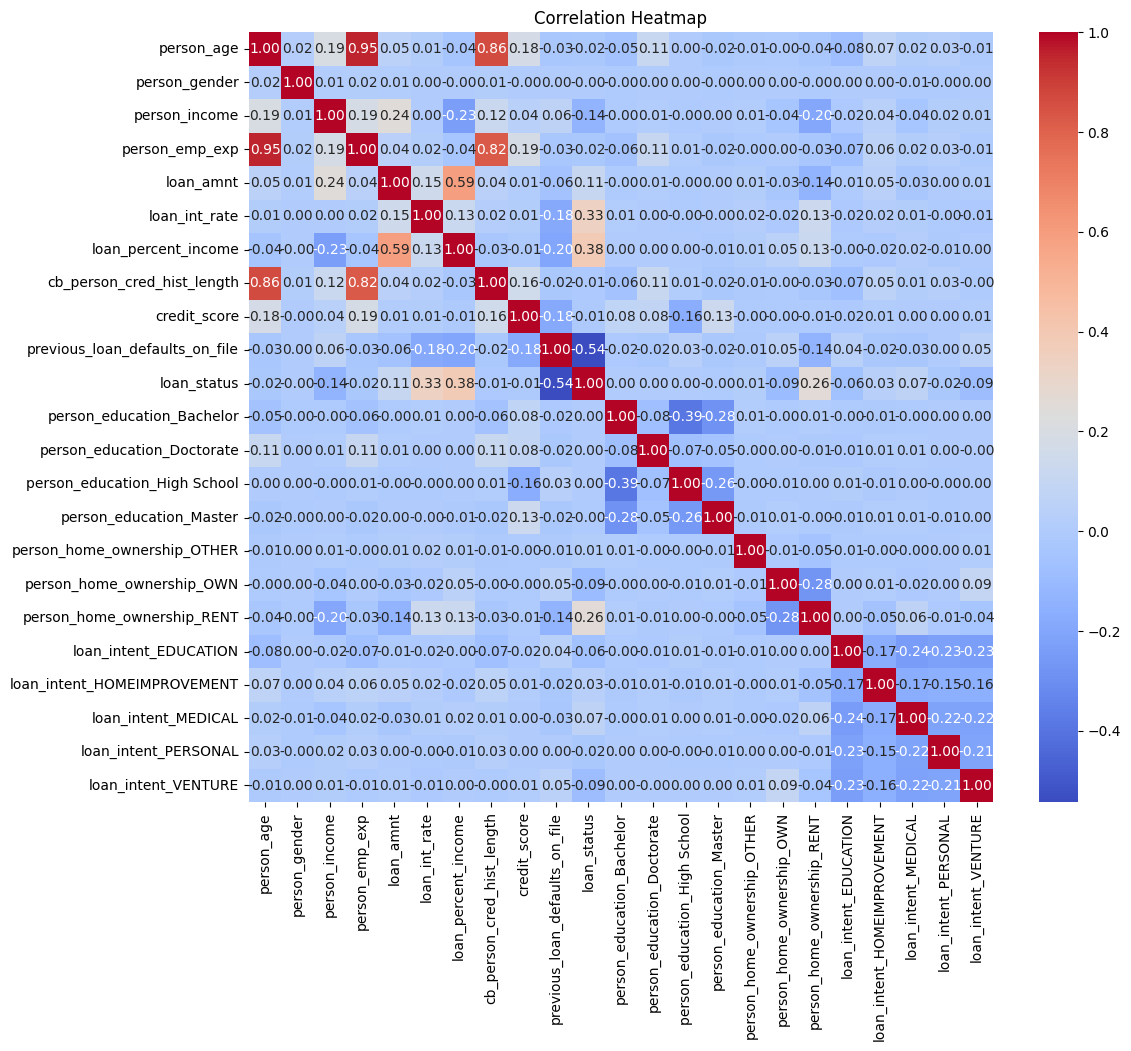

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df1=df.copy()
df1['person_gender'] = le.fit_transform(df1['person_gender'])
df1['previous_loan_defaults_on_file'] = le.fit_transform(df1['previous_loan_defaults_on_file'])
df1 = pd.get_dummies(df1, columns=['person_education', 'person_home_ownership', 'loan_intent'], drop_first=True,dtype=int)
correlation_matrix = df1.corr()
#print(correlation_matrix['loan_status'].sort_values(ascending=False))
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Question: Which variables seem most correlated with loan approval? Which variables are weak predictors?




Part 2 – Building a Decision Tree Classifier

Step 1 – Splitting the dataset
We don’t want to test our model on the same data we train it on → risk of overfitting.
So we split into Train, Validation, Test sets:
Train (60%) → learn model parameters
Validation (20%) → tune hyperparameters (max depth, criterion, …)
Test (20%) → final evaluation, untouched until the end

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def make_data(df, cols=None, verbos=False):
    # Features & Target
    X = df.drop(columns=["loan_status"])
    if cols:
        X = X[cols]
    y = df["loan_status"]

    # Splits
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    RANDOM_STATE = 42

    # First split off test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Then split temp into train/val
    val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=RANDOM_STATE
    )

    if verbos:
        print(
            f"Train: {len(X_train)} ({(1-TEST_SIZE-VAL_SIZE):.0%}) | "
            f"Val: {len(X_val)} ({VAL_SIZE:.0%}) | "
            f"Test: {len(X_test)} ({TEST_SIZE:.0%})"
        )

    # Identify column types
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number, "float64", "int64"]).columns.tolist()

    # Preprocessor: OneHot for categorical, passthrough for numeric
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ("num", "passthrough", num_cols),
        ]
    )
    return X_train, X_val, X_test, y_train, y_val, y_test, cat_cols, num_cols, preprocess

Question : Why do we use stratify=y in train_test_split?


Step 2 – Training a Decision Tree
We’ll start with a shallow tree (max_depth=3) for interpretability, just like in the Iris demo

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

def model_tree(preprocess, X_train, X_val, y_train, y_val, max_depth=3, criterion="gini", val=True):
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=42)
    model = Pipeline(steps=[("prep", preprocess), ("tree", tree_clf)])
    model.fit(X_train, y_train)

    if val:
        y_pred = model.predict(X_val)
        print(classification_report(y_val, y_pred, digits=3))
    return model

Question: What is the difference between gini and entropy criteria in Decision Trees ? (optionally try entropy later) 


In [10]:
# Prepare splits
X_train, X_val, X_test, y_train, y_val, y_test, cat_cols, num_cols, preprocess = make_data(df, verbos=True)

# Train a simple tree
model = model_tree(preprocess, X_train, X_val, y_train, y_val, max_depth=5, val=True)

Train: 27000 (60%) | Val: 9000 (20%) | Test: 9000 (20%)
              precision    recall  f1-score   support

           0      0.923     0.964     0.943      7000
           1      0.852     0.717     0.779      2000

    accuracy                          0.909      9000
   macro avg      0.887     0.841     0.861      9000
weighted avg      0.907     0.909     0.906      9000



Question: Look at the classification report. Which metric matters most for the bank: precision (avoiding false approvals) or recall (not missing too many good customers)?


In [11]:
import os

path_file = "DT/images/loan_tree.dot"

os.makedirs(os.path.dirname(path_file), exist_ok=True)

In [12]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


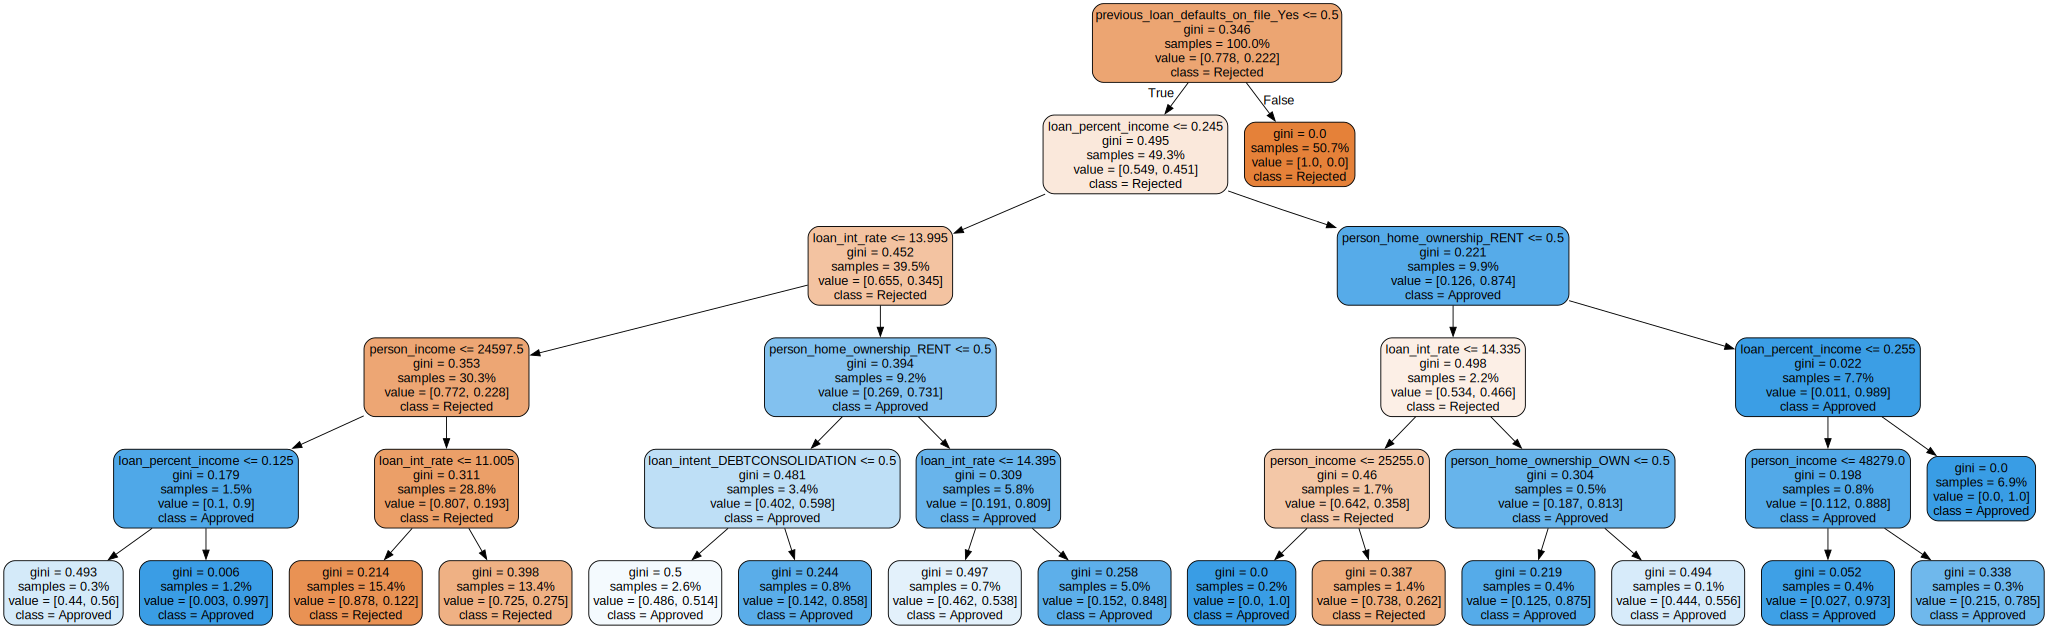

In [13]:
from sklearn.tree import export_graphviz
from graphviz import Source
import os

# Recover one-hot encoded feature names
ohe = model.named_steps["prep"].named_transformers_["cat"]
ohe_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[ohe_names, num_cols]

# Export tree
path_file = "DT/images/loan_tree.dot"
export_graphviz(
    model.named_steps["tree"],
    out_file=path_file,
    feature_names=feature_names,
    class_names=["Rejected", "Approved"],
    rounded=True,
    filled=True,
    proportion=True,
    impurity=True
)
Source.from_file(path_file)

Question: Find one rule from the tree (e.g., “If income ≤ 25,000 → Reject”). What business intuition does it represent?


Part 3 – Interpreting the Decision Tree
Now that we have trained a Decision Tree, let’s understand what it learned:
Which features are most important?
How do we visualize the decision boundaries in 2D?

Step 1 – Feature Importance
Decision Trees assign an importance score to each feature based on how much it reduces impurity (Gini/Entropy).

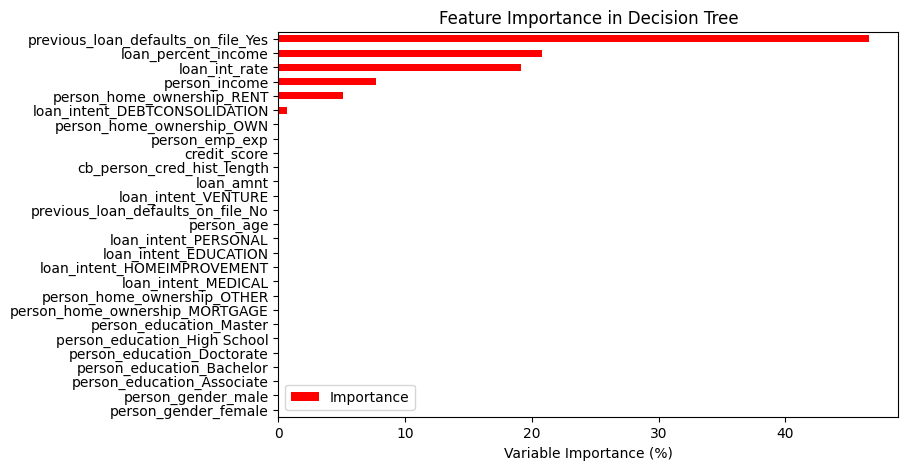

In [14]:
# Extract feature names after preprocessing
feature_names = [i[5:] for i in model.named_steps['prep'].get_feature_names_out()]

# Get feature importances from classifier
importances = model.named_steps['tree'].feature_importances_ * 100

# Build DataFrame
Importance = pd.DataFrame({'Importance': importances}, index=feature_names)

# Sort and plot
Importance.sort_values('Importance').plot(kind='barh', color='r', figsize=(8,5))
plt.xlabel('Variable Importance (%)')
plt.title("Feature Importance in Decision Tree")
plt.show()

Question: Which features are most important in predicting loan approval? Why does this make sense from a banking perspective?




Step 2 – Focus on two features for visualization
For easy plotting, let’s choose just two numerical features:
loan_int_rate → the loan’s interest rate
loan_percent_income → what fraction of income goes to loan payments
This creates a 2D feature space where we can plot decision regions.

In [15]:
cols = ["loan_int_rate", "loan_percent_income"]

X_train, X_val, X_test, y_train, y_val, y_test, cat_cols, num_cols, preprocess = make_data(df, cols=cols)

model = model_tree(preprocess, X_train, X_val, y_train, y_val,
                   max_depth=3, val=True)  # shallow tree for clear boundaries

              precision    recall  f1-score   support

           0      0.875     0.919     0.896      7000
           1      0.656     0.540     0.592      2000

    accuracy                          0.835      9000
   macro avg      0.766     0.730     0.744      9000
weighted avg      0.826     0.835     0.829      9000



In [17]:
pip install utils

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=14012 sha256=c573fc344c06ed32b4a30e8cff9afe5aca31246abf5017c6e8b1c61565fc0b99
  Stored in directory: c:\users\nina\appdata\local\pip\cache\wheels\cd\95\b5\2513b327cdc0ef5f9b087f0596bff56100e7ec84e0d0f4ed18
Successfully built utils
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from utils import plot_decision_boundary_binary


plot_decision_boundary_binary(
    model, X_train[:1000], y_train[:1000], feature_names=cols,
    title="Loan Approval Decision Boundary (max_depth=3)"
)
plt.show()

Question: How do the decision boundaries look? Do they match business logic?
